In [3]:
import os
import re
import subprocess
from collections import defaultdict
import numpy as np
import rasterio
from rasterio.merge import merge
from rasterio.warp import reproject, Resampling
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob

#import geopandas as gpd
import pandas as pd

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

# from utils import *
# from utils import basics as bsc
# from utils import plotting as pt

import utils.basics as bsc 
import utils.plotting as pt

# import importlib
# importlib.reload(pt)


In [4]:
# PATHS
S2_stacked_1 = "../data/02_processed/S2_Stacked_Site_1.tif"
S2_stacked_2 = "../data/02_processed/S2_Stacked_Site_2.tif"
ALS_PATH1_RES = "../data/02_processed/ALS_resampled_site1.tif"
ALS_PATH2_RES = "../data/02_processed/ALS_resampled_site2.tif"
ALS_PATH1_P = '../data/02_processed/ALS_GT01_2024_processed.tif'
ALS_PATH2_P = '../data/02_processed/ALS_GT02_2024_processed.tif'

## load rasters

In [5]:
# Load S2 and merged ALS data for both sites and combine them in an array
s2_np, als_np = bsc.load_rasters(S2_stacked_1, ALS_PATH1_RES)
s2_np2, als_np2 = bsc.load_rasters(S2_stacked_2, ALS_PATH2_RES)

✅ Loaded S2: (13, 846, 1241), ALS: (846, 1241)
S2_Stacked_Site_1.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 10.00 x 9.99 metre

ALS_resampled_site1.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 10.00 x 9.99 metre

✅ Loaded S2: (13, 1002, 815), ALS: (1002, 815)
S2_Stacked_Site_2.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 9.99 x 10.00 metre

ALS_resampled_site2.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 9.99 x 10.00 metre



In [ ]:
with rasterio.open(S2_stacked_1) as s2_src:
    s2np = s2_src.read().astype(np.float32)  # shape: (bands, height, width)
    s2res_x, s2res_y = s2_src.res  # (pixel width, pixel height in coordinate units)
    s2crs = s2_src.crs
    # Print band (channel) descriptions if available
    print(s2_src.descriptions)
    # the descriptioons are all none, fix them
    # s2_src.descriptions = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
    # TO-DO: fix this in the data processing step


(None, None, None, None, None, None, None, None, None, None, None, None, None)


## plot the images

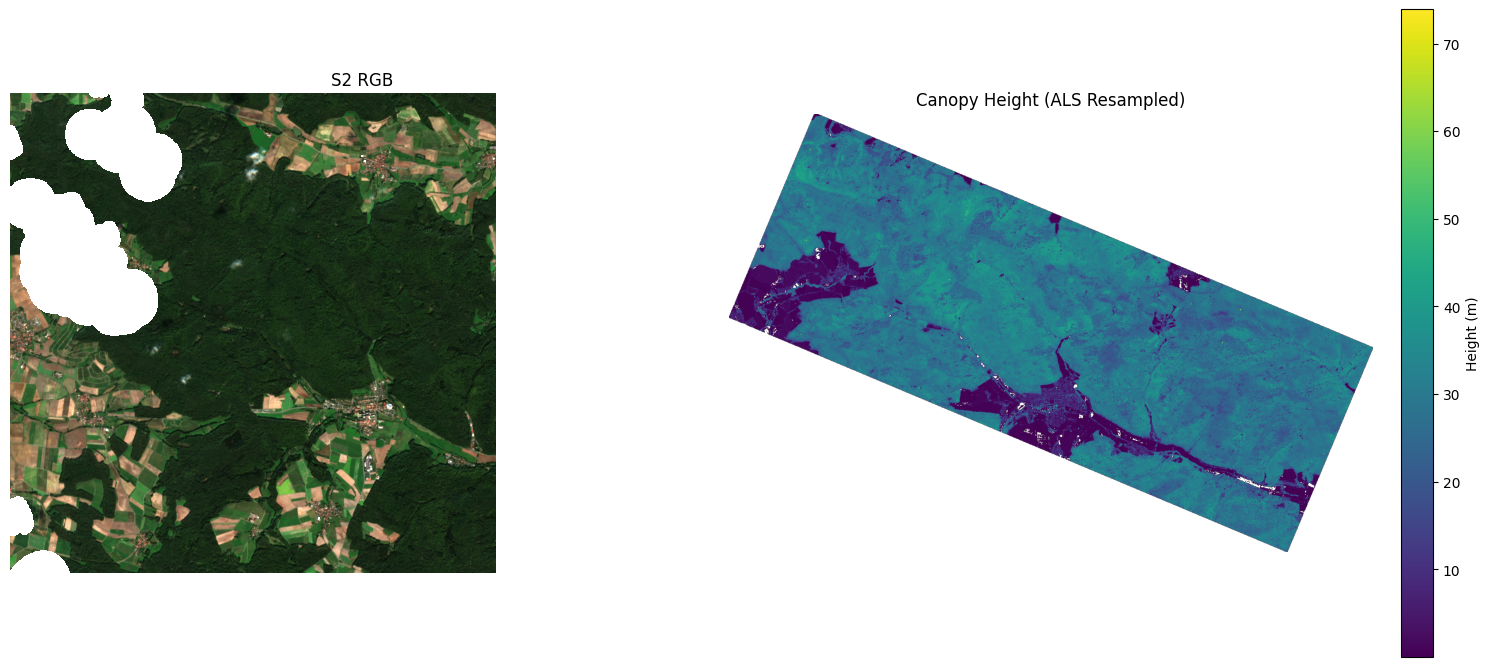

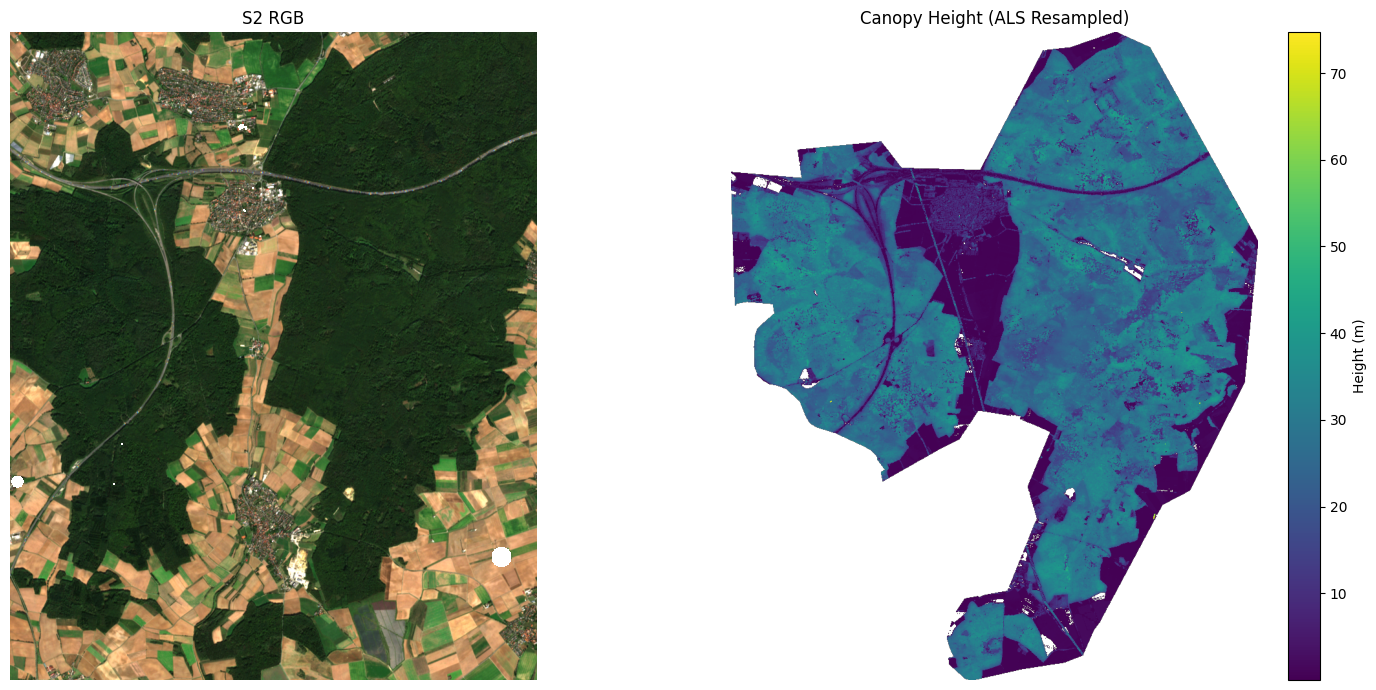

In [6]:
pt.plot_full_image(s2_np, als_np)
pt.plot_full_image(s2_np2, als_np2)

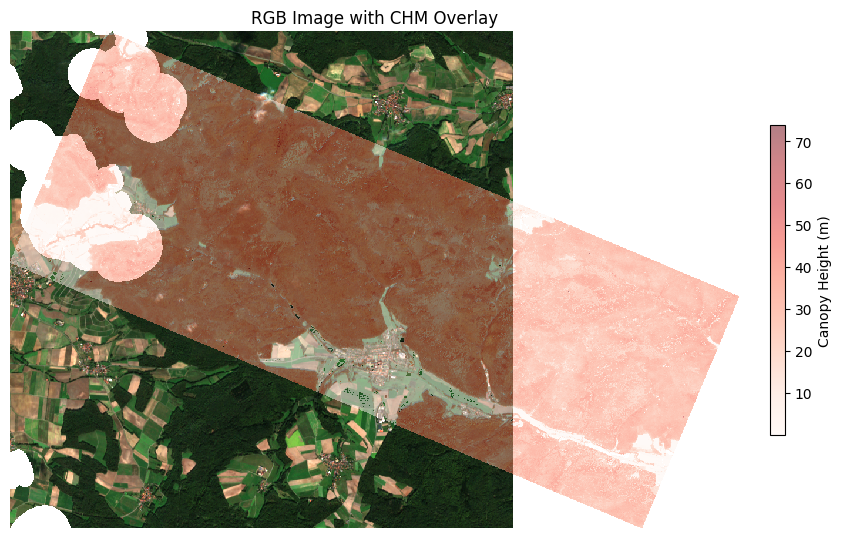

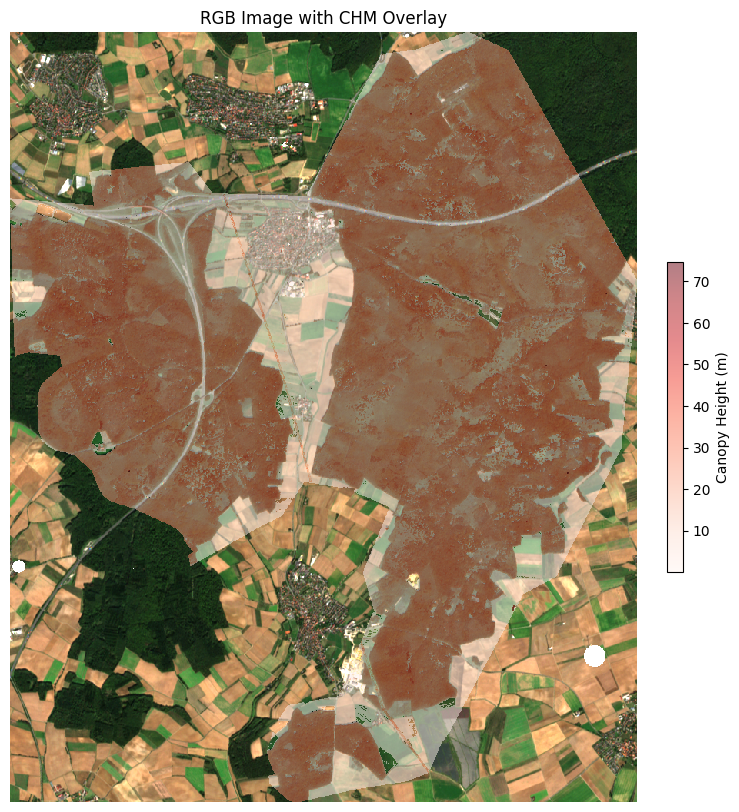

In [7]:
pt.plot_overlay(s2_np, als_np)
pt.plot_overlay(s2_np2, als_np2)

## get data stats

In [8]:
# Get file sizes in megabytes (MB)
als_file_size = os.path.getsize(ALS_PATH2_RES) / (1024 * 1024)  # Convert bytes to MB
s2_file_size = os.path.getsize(S2_stacked_2) / (1024 * 1024)  # Convert bytes to MB

print(f"ALS file size: {als_file_size:.2f} MB")
print(f"S2 stacked multiband file size: {s2_file_size:.2f} MB")

ALS file size: 3.12 MB
S2 stacked multiband file size: 20.25 MB


In [9]:
def calculate_coverage_and_area(als, s2, band_idx=3, pixel_size=10):
    """
    Calculate the coverage and overlap between ALS and a specific S2 band.

    Parameters:
    - als: numpy array of ALS data (height, width)
    - s2: numpy array of S2 data (bands, height, width)
    - band_idx: index of the S2 band to compare (default: 3 for green channel)
    - pixel_size: size of one pixel in meters (default: 10m x 10m)

    Returns:
    - valid_pixel_count: number of valid overlapping pixels
    - percentage: percentage of ALS pixels with valid S2 data
    - area: area in square meters of valid overlapping pixels
    """
    # Mask invalid ALS and S2 data
    als_valid = ~np.isnan(als) & (als >= 0)
    s2_valid = ~np.isnan(s2[band_idx]) & (s2[band_idx] >= 0)

    # Calculate overlap
    valid_overlap = als_valid & s2_valid
    valid_pixel_count = np.sum(valid_overlap)

    # Calculate percentage and area
    total_als_pixels = np.sum(als_valid)
    percentage = (valid_pixel_count / total_als_pixels) * 100 if total_als_pixels > 0 else 0
    als_area_full = np.sum(als_valid) * (pixel_size ** 2) / 1e6   # Area in square kilometers
    area_km2_avail = valid_pixel_count * (pixel_size ** 2) / 1e6  # Convert to square kilometers

    # Calculate percentage of vegetated area with data availability
    vegetated_area = np.sum((als > 2) & ~np.isnan(als))
    vegetated_overlap = np.sum((als > 2) & valid_overlap)
    vegetated_percentage = (vegetated_overlap / vegetated_area) * 100 if vegetated_area > 0 else 0

    print(f"ALS area (all valid CHM):             {als_area_full:10.2f} km²")
    print(f"Valid overlapping pixels:               {valid_pixel_count:10,d}")
    print(f"Area of valid overlapping pixels:     {area_km2_avail:10.2f} km²")
    print(f"ALS pixels with valid S2 data:        {percentage:10.2f} %")
    print(f"Vegetated area with data availability:{vegetated_percentage:10.2f} % (CHM > 2m)")

    return #valid_pixel_count, percentage, als_area_full, area_km2_avail, vegetated_percentage


In [12]:
calculate_coverage_and_area(als_np, s2_np, band_idx=3)

ALS area (all valid CHM):                  49.85 km²
Valid overlapping pixels:                  303,737
Area of valid overlapping pixels:          30.37 km²
ALS pixels with valid S2 data:             60.93 %
Vegetated area with data availability:     61.06 % (CHM > 2m)


In [11]:
calculate_coverage_and_area(als_np2, s2_np2, band_idx=3)

ALS area (all valid CHM):                  44.41 km²
Valid overlapping pixels:                  444,046
Area of valid overlapping pixels:          44.40 km²
ALS pixels with valid S2 data:            100.00 %
Vegetated area with data availability:    100.00 % (CHM > 2m)


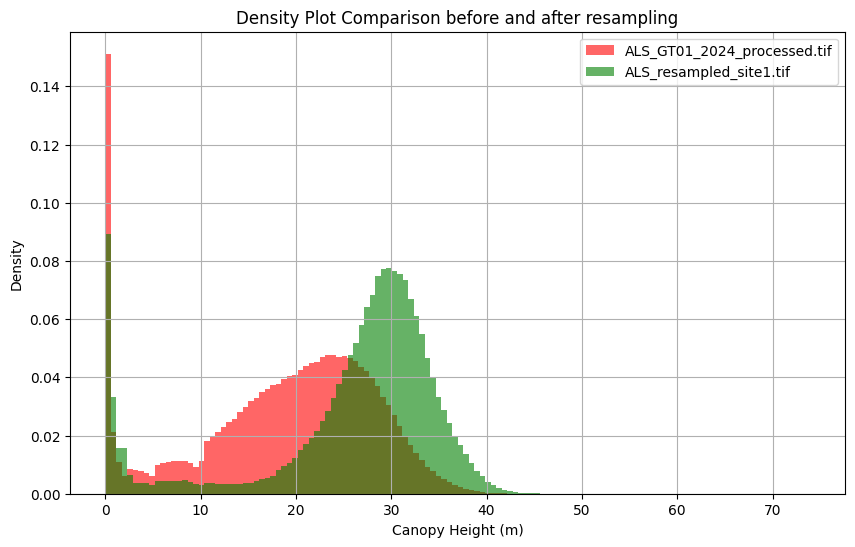


Percentiles Table:
            ALS_GT01_2024_processed.tif  ALS_resampled_site1.tif  delta
Percentile                                                             
0th                                0.00                     0.01   0.01
5th                                0.13                     0.56   0.43
10th                               1.18                     5.09   3.91
50th                              20.50                    28.55   8.05
75th                              25.91                    31.85   5.94
90th                              29.66                    34.66   5.00
95th                              31.70                    36.41   4.71
98th                              33.98                    38.25   4.27
99th                              35.46                    39.43   3.97
100th                             73.91                    73.91   0.00


In [5]:
pt.plot_two_density_and_percentiles(ALS_PATH1_P, ALS_PATH1_RES)

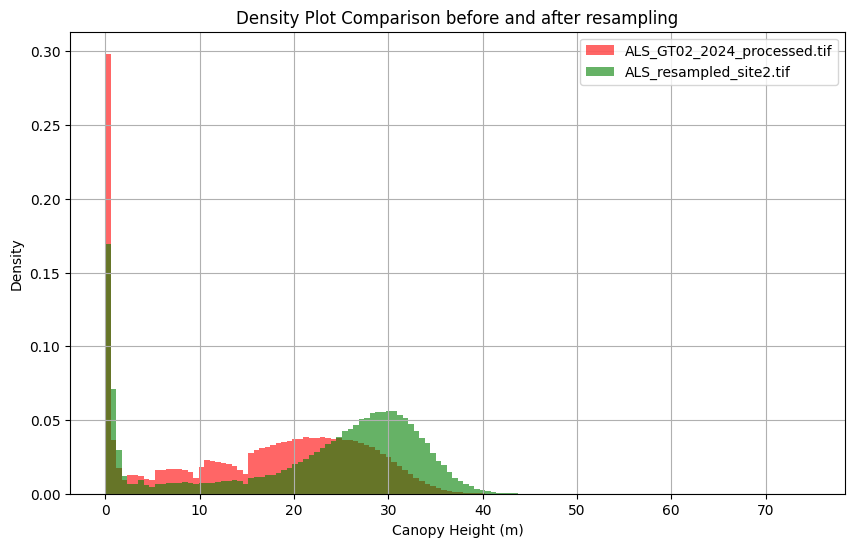


Percentiles Table:
            ALS_GT02_2024_processed.tif  ALS_resampled_site2.tif  delta
Percentile                                                             
0th                                0.00                     0.01   0.01
5th                                0.08                     0.39   0.31
10th                               0.20                     0.60   0.40
50th                              17.93                    25.78   7.85
75th                              24.69                    30.57   5.88
90th                              29.05                    33.67   4.62
95th                              31.11                    35.31   4.20
98th                              33.21                    37.14   3.93
99th                              34.55                    38.34   3.79
100th                             74.69                    74.69   0.00


In [6]:
pt.plot_two_density_and_percentiles(ALS_PATH2_P, ALS_PATH2_RES)

--> Cool, this distribution is somehow expected when doing a 98th percentile aggregation. We shift the distribution slightly to the right. 

## S2 Band names workaorund

In [53]:
# Get band names from .vrt files in the S2_VRT folder
def get_band_names_from_vrt_folder(folder_path):
    vrt_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.vrt')])
    band_names = [os.path.splitext(f)[0][:3] for f in vrt_files]
    return band_names, vrt_files

S2_VRT_folder = "../data/02_processed/S2_VRT"
band_names, vrt_files = get_band_names_from_vrt_folder(S2_VRT_folder)
print("Band names from VRT files (in order):")
for idx, (name, fname) in enumerate(zip(band_names, vrt_files)):
    print(f"Band {idx+1}: {name} ({fname})")

# write the band names to the S2 stacked files
def write_band_names_to_raster(raster_path, band_names):
    with rasterio.open(raster_path, 'r+') as src:
        src.descriptions = band_names
        print(f"Band names written to {raster_path}")
write_band_names_to_raster(S2_stacked_1, band_names)
write_band_names_to_raster(S2_stacked_2, band_names)

# now also store the band names such that we can use them later with stacked np arrays
# numpy arrays do not support custom attributes like 'band_names'
# Instead, store the band names in a separate variable for later use
s2_band_names_np = band_names  # Use this variable alongside s2_np when needed


Band names from VRT files (in order):
Band 1: BLU (BLU_STM.vrt)
Band 2: BNR (BNR_STM.vrt)
Band 3: EVI (EVI_STM.vrt)
Band 4: GRN (GRN_STM.vrt)
Band 5: NBR (NBR_STM.vrt)
Band 6: NDV (NDV_STM.vrt)
Band 7: NIR (NIR_STM.vrt)
Band 8: RE1 (RE1_STM.vrt)
Band 9: RE2 (RE2_STM.vrt)
Band 10: RE3 (RE3_STM.vrt)
Band 11: RED (RED_STM.vrt)
Band 12: SW1 (SW1_STM.vrt)
Band 13: SW2 (SW2_STM.vrt)
Band names written to ../data/02_processed/S2_Stacked_Site_1.tif
Band names written to ../data/02_processed/S2_Stacked_Site_2.tif


In [54]:
s2_band_names_np

['BLU',
 'BNR',
 'EVI',
 'GRN',
 'NBR',
 'NDV',
 'NIR',
 'RE1',
 'RE2',
 'RE3',
 'RED',
 'SW1',
 'SW2']

In [50]:
# little workaround to get the s2 band names
def get_s2_band_names(s2_path):
    with rasterio.open(s2_path) as src:
        band_names = src.descriptions
    return band_names
s2_band_names = get_s2_band_names(S2_stacked_1)
print("S2 Band Names:")
for i, name in enumerate(s2_band_names):
    print(f"Band {i+1}: {name if name else 'No description available'}")

S2 Band Names:
Band 1: BLU
Band 2: BNR
Band 3: EVI
Band 4: GRN
Band 5: NBR
Band 6: NDV
Band 7: NIR
Band 8: RE1
Band 9: RE2
Band 10: RE3
Band 11: RED
Band 12: SW1
Band 13: SW2


## S2 Histograms

Band 1  Band 2    Band 3  Band 4  Band 5  Band 6  Band 7   Band 8  \
P0       20.0   168.0      0.00    53.0     0.0     0.0    59.0    73.00   
P0.1     65.0   407.0    474.06   115.0    21.0   950.0   584.0   233.49   
P25     155.0  2323.0   4533.00   303.0  6015.0  7928.0  2548.0   552.00   
P50     185.0  2786.0   5279.00   364.0  6992.0  8731.0  2944.0   646.00   
P75     328.0  3226.0   5821.00   639.0  7270.0  8930.0  3307.0  1023.00   
P95     726.0  4246.0   6971.00  1014.0  7551.0  9136.0  4255.0  1468.00   
P99.9  1306.0  6108.0   9592.00  1594.0  8030.0  9452.0  6121.0  2150.51   
P100   6898.0  7838.0  25990.00  7487.0  8462.0  9800.0  7261.0  6294.00   

       Band 9  Band 10  Band 11  Band 12  Band 13  
P0      123.0    71.00    13.00     84.0     48.0  
P0.1    502.0   577.49    53.00    294.0    116.0  
P25    1802.0  2251.00   168.00   1212.0    468.0  
P50    2062.0  2601.00   204.00   1353.0    535.0  
P75    2340.0  2943.00   394.00   1814.0    933.0  
P95    3398.0  3973.00  1189.00   2361.0   1716.0  
P99.9  4941.0  5883.51  1975.51   3094.0   2651.0  
P100   6025.0  6981.00  8109.00   5942.0   5956.0

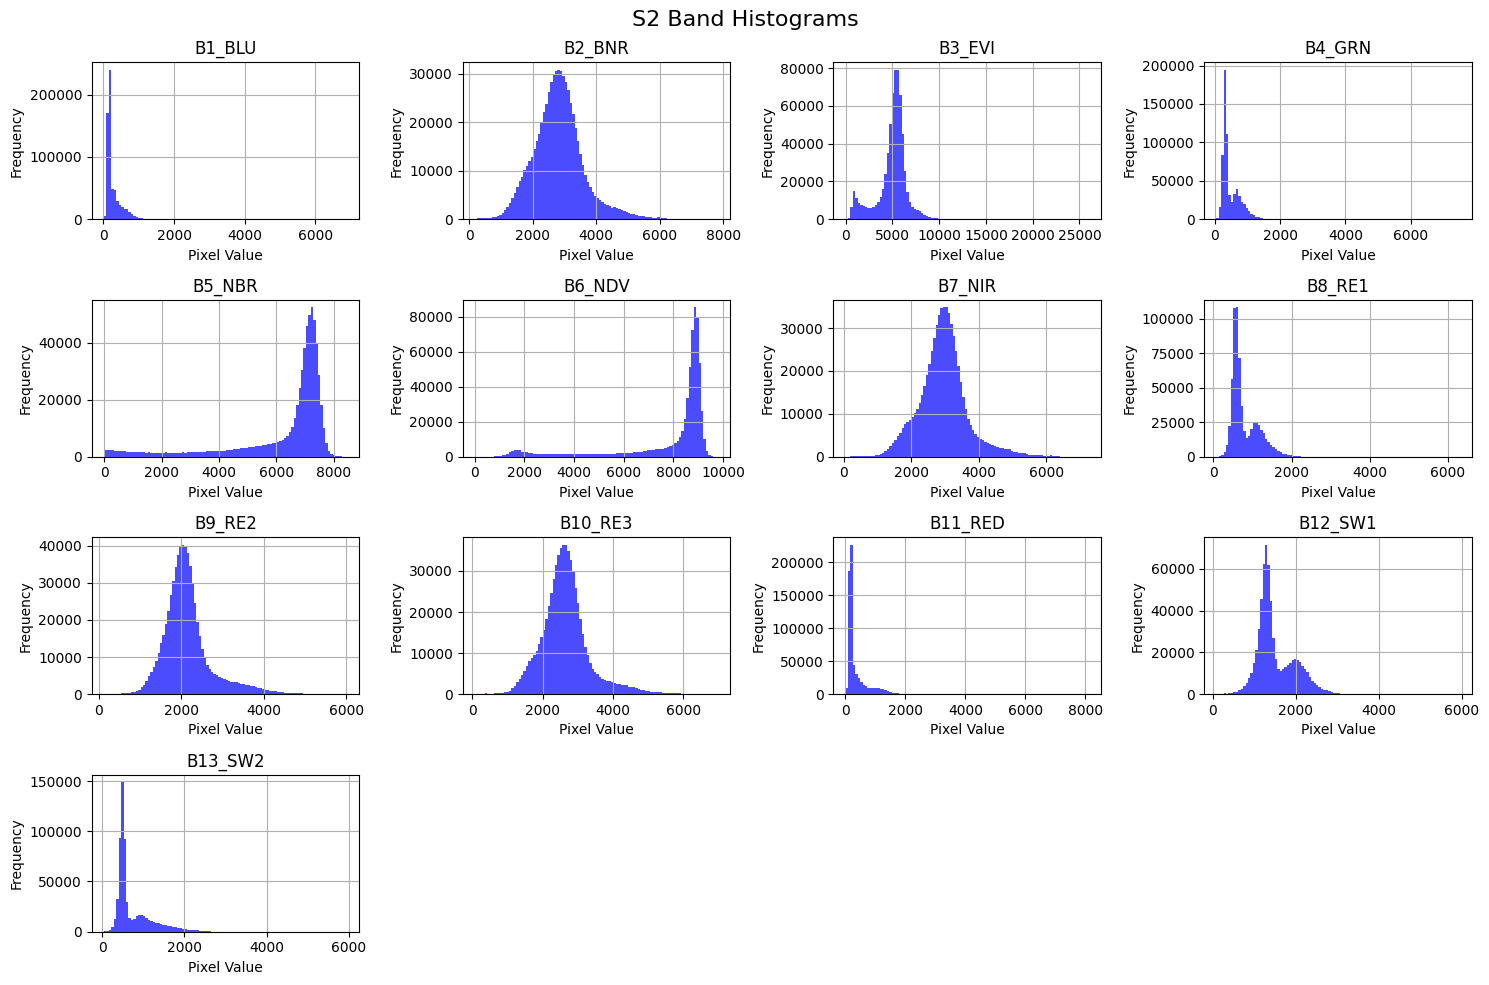

In [57]:
def plot_s2_histograms(s2_data, num_bands=13,band_names=None):
    """
    Plot histograms for each band in the S2 data and print nanmax, nanmin, nanmean, nanmedian per band.

    Parameters:
    - s2_data: numpy array of S2 data (bands, height, width)
    - num_bands: number of bands in the S2 data (default: 13)
    """
    plt.figure(figsize=(15, 10))

    percentiles = [0, 0.1, 25, 50, 75, 95, 99.9, 100]
    table = []
    
    for i in range(num_bands):

        band_data = s2_data[i].flatten()
        band_data_nonan = band_data[~np.isnan(band_data)]
        band_data = s2_data[i].flatten()
        band_data_nonan = band_data[~np.isnan(band_data)]
        pct_values = np.percentile(band_data_nonan, percentiles)
        table.append(pct_values)
        # plots 
        plt.subplot(4, 4, i + 1)
        plt.hist(band_data_nonan, bins=100, color='blue', alpha=0.7)
        plt.title(f'B{i + 1}_{band_names[i]}' if band_names else f'na')
        plt.xlabel('Pixel Value')
        plt.ylabel('Frequency')
        plt.grid(True)
        #print(f"Band {i+1:2d}: max={np.nanmax(band_data):.2f}, min={np.nanmin(band_data):.2f}, mean={np.nanmean(band_data):.2f}, median={np.nanmedian(band_data):.2f}")
    df = pd.DataFrame(
        np.array(table).T,
        index=[f"P{p}" for p in percentiles],
        columns=[f"Band {i+1}" for i in range(num_bands)]
    )

    #print(df.round(2))
    display(df.round(2))
    plt.suptitle('S2 Band Histograms', fontsize=16)
    plt.tight_layout()
    plt.show()

plot_s2_histograms(s2_np, num_bands=13,band_names=s2_band_names_np)

Which Bands to drop:
- EVI
- NBR 
- NDV 
--> drop them, cause they re indices, made up from the other bands. 
we drop them for better comparability to other approaches. 
-> Hypothesis: Model should learn better with Indices. 

How to normalize the remaining:
- push everything between 0 and 1. 
- index values -1 to 1. (?)



In [ ]:

def normalize_s2_data(s2_data):
    """
    Normalize S2 data to the range [0, 1] for each band.

    Parameters:
    - s2_data: numpy array of S2 data (bands, height, width)

    Returns:
    - normalized_s2: numpy array of normalized S2 data
    """
    normalized_s2 = np.zeros_like(s2_data, dtype=np.float32)

    # TO-DO: fix normalization to overall scale range of all bands, not min/max per band
    
    for i in range(s2_data.shape[0]):
        band_data = s2_data[i]
        band_min = np.nanmin(band_data)
        band_max = np.nanmax(band_data)
        # Avoid division by zero
        if band_max - band_min > 0:
            normalized_s2[i] = (band_data - band_min) / (band_max - band_min)
        else:
            normalized_s2[i] = 0  # If all values are the same, set to 0

    return normalized_s2
# Normalize the S2 data
s2_1n = normalize_s2_data(s2_np)
s2_2n = normalize_s2_data(s2_np2)

Band 1  Band 2  Band 3  Band 4  Band 5  Band 6  Band 7  Band 8  Band 9  \
P0       0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
P0.1     0.01    0.03    0.02    0.01    0.00    0.10    0.07    0.03    0.06   
P25      0.02    0.28    0.17    0.03    0.71    0.81    0.35    0.08    0.28   
P50      0.02    0.34    0.20    0.04    0.83    0.89    0.40    0.09    0.33   
P75      0.04    0.40    0.22    0.08    0.86    0.91    0.45    0.15    0.38   
P95      0.10    0.53    0.27    0.13    0.89    0.93    0.58    0.22    0.55   
P99.9    0.19    0.77    0.37    0.21    0.95    0.96    0.84    0.33    0.82   
P100     1.00    1.00    1.00    1.00    1.00    1.00    1.00    1.00    1.00   

       Band 10  Band 11  Band 12  Band 13  
P0        0.00     0.00     0.00     0.00  
P0.1      0.07     0.00     0.04     0.01  
P25       0.32     0.02     0.19     0.07  
P50       0.37     0.02     0.22     0.08  
P75       0.42     0.05     0.30     0.15  
P95       0.56     0.15     0.39     0.28  
P99.9     0.84     0.24     0.51     0.44  
P100      1.00     1.00     1.00     1.00

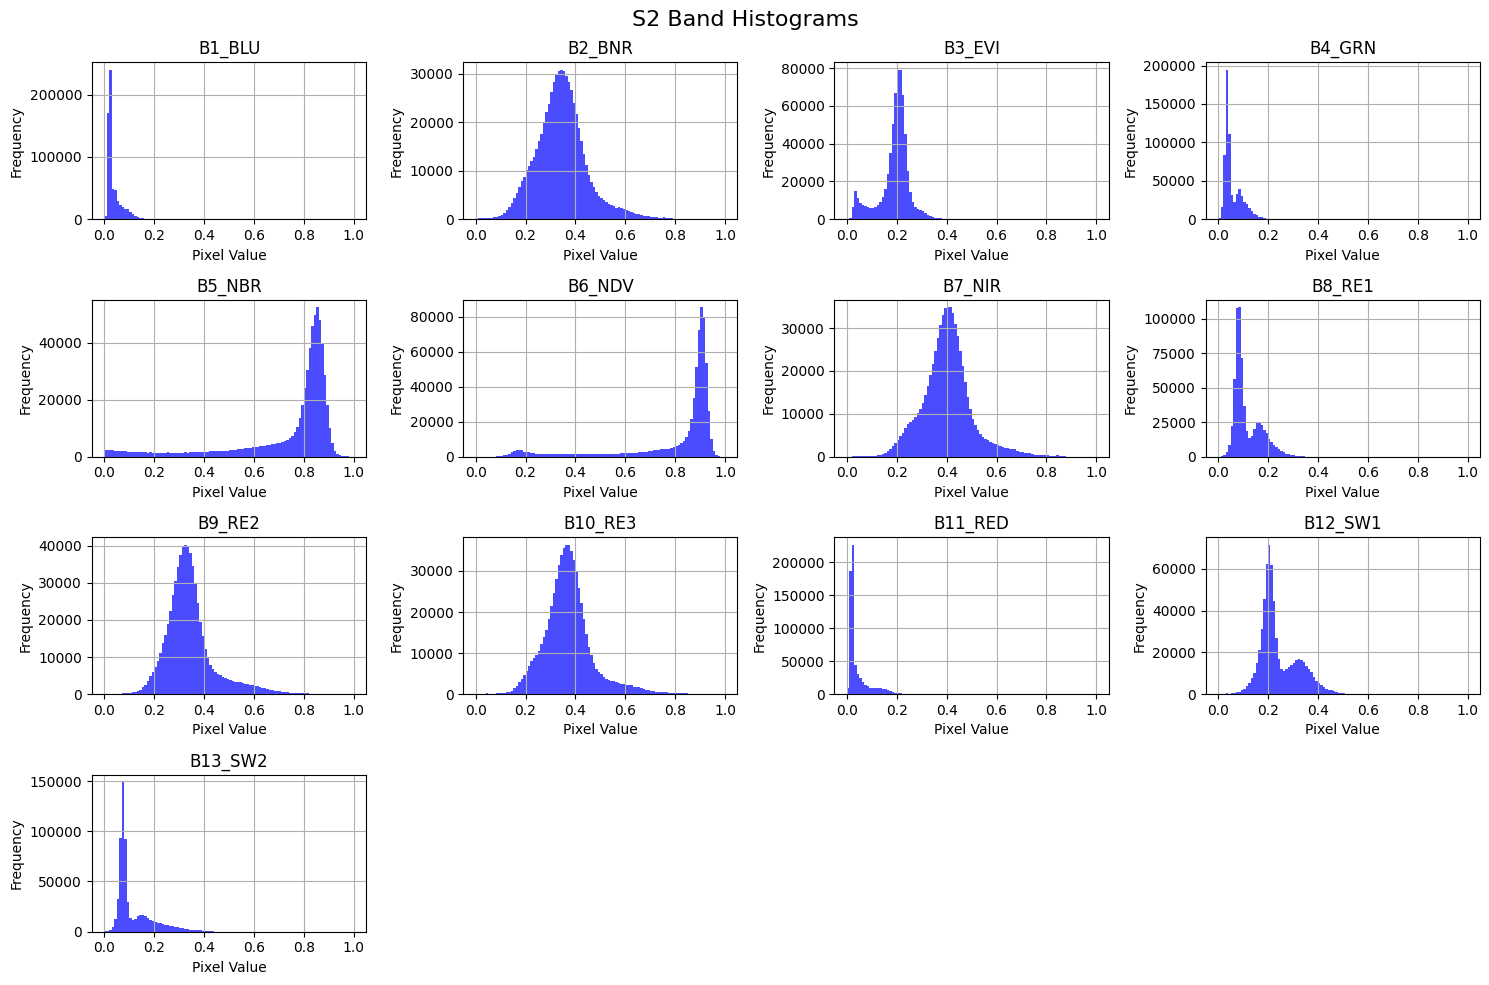

Band 1  Band 2  Band 3  Band 4  Band 5  Band 6  Band 7  Band 8  Band 9  \
P0       0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
P0.1     0.01    0.04    0.02    0.01    0.00    0.06    0.09    0.02    0.04   
P25      0.02    0.15    0.17    0.04    0.40    0.45    0.27    0.04    0.13   
P50      0.03    0.19    0.32    0.05    0.77    0.86    0.33    0.05    0.15   
P75      0.07    0.22    0.37    0.12    0.83    0.90    0.39    0.10    0.17   
P95      0.10    0.28    0.43    0.16    0.87    0.93    0.47    0.13    0.24   
P99.9    0.23    0.42    0.58    0.29    0.98    0.96    0.69    0.19    0.36   
P100     1.00    1.00    1.00    1.00    1.00    1.00    1.00    1.00    1.00   

       Band 10  Band 11  Band 12  Band 13  
P0        0.00     0.00     0.00     0.00  
P0.1      0.07     0.00     0.03     0.02  
P25       0.20     0.02     0.09     0.06  
P50       0.25     0.02     0.11     0.08  
P75       0.29     0.08     0.19     0.21  
P95       0.37     0.14     0.25     0.32  
P99.9     0.58     0.21     0.33     0.42  
P100      1.00     1.00     1.00     1.00

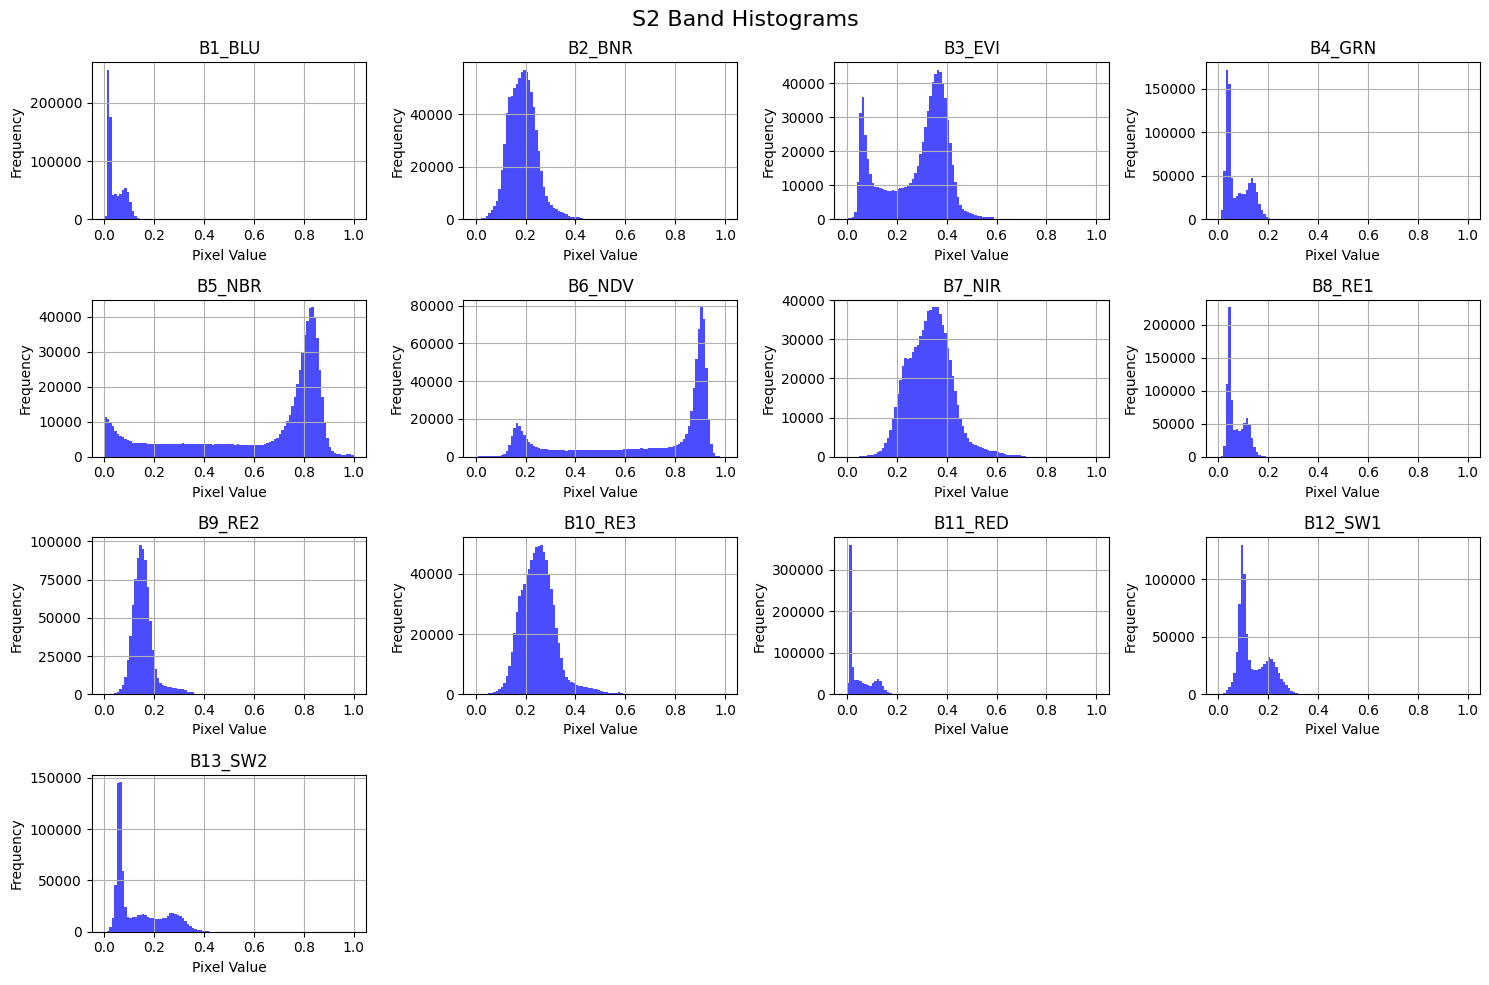

In [61]:
plot_s2_histograms(s2_1n, num_bands=13,band_names=s2_band_names_np)
plot_s2_histograms(s2_2n, num_bands=13,band_names=s2_band_names_np)

In [63]:
#now save the normalized data to a new file
def save_normalized_s2(s2_data, output_path, band_names):
    """
    Save normalized S2 data to a new file.

    Parameters:
    - s2_data: numpy array of normalized S2 data (bands, height, width)
    - output_path: path to save the normalized S2 data
    - band_names: list of band names for the raster metadata
    """
    with rasterio.open(output_path, 'w', driver='GTiff',
                       height=s2_data.shape[1], width=s2_data.shape[2],
                       count=s2_data.shape[0], dtype=s2_data.dtype,
                       crs=s2crs, transform=s2_src.transform) as dst:
        dst.descriptions = band_names
        dst.write(s2_data)
save_normalized_s2(s2_1n, "../data/02_processed/S2_Stacked_Site_1_norm.tif", s2_band_names_np)
save_normalized_s2(s2_2n, "../data/02_processed/S2_Stacked_Site_2_norm.tif", s2_band_names_np)


✅ Loaded S2: (13, 846, 1241), ALS: (846, 1241)
S2_Stacked_Site_1_norm.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 10.00 x 9.99 metre

ALS_resampled_site1.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 10.00 x 9.99 metre

✅ Loaded S2: (13, 1002, 815), ALS: (1002, 815)
S2_Stacked_Site_2_norm.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 10.00 x 9.99 metre

ALS_resampled_site2.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 9.99 x 10.00 metre



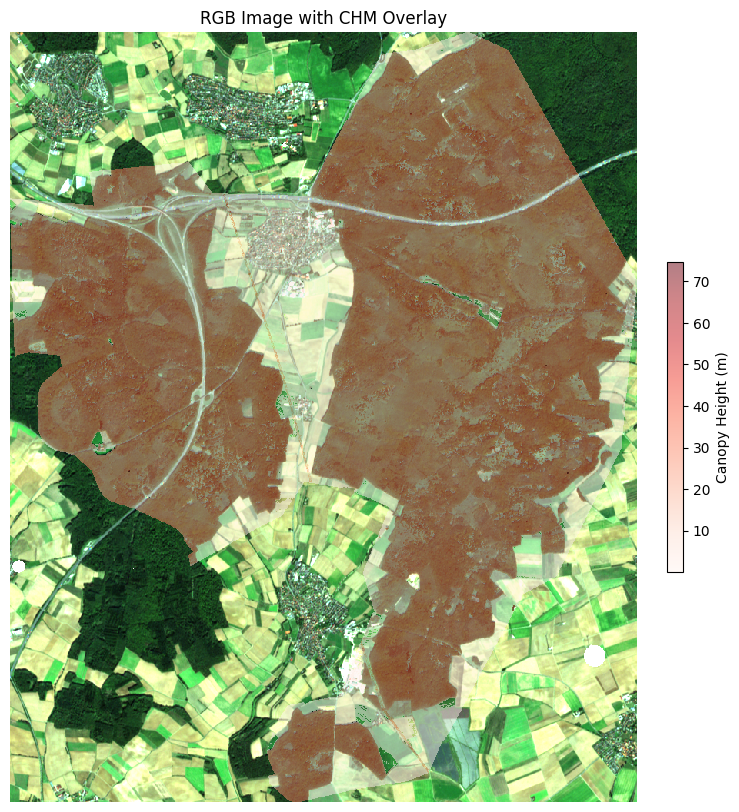

In [65]:
# Now we can load the normalized data and check the histograms again
s2_np_norm, _ = bsc.load_rasters("../data/02_processed/S2_Stacked_Site_1_norm.tif", ALS_PATH1_RES)
s2_np2_norm, _ = bsc.load_rasters("../data/02_processed/S2_Stacked_Site_2_norm.tif", ALS_PATH2_RES)
#plot_s2_histograms(s2_np_norm, num_bands=13, band_names=s2_band_names_np)
#plot_s2_histograms(s2_np2_norm, num_bands=13, band_names=s2_band_names_np)
# Now we can also plot the normalized data
#pt.plot_full_image(s2_np_norm, als_np)
# pt.plot_full_image(s2_np2_norm, als_np2)
# pt.plot_overlay(s2_np_norm, als_np)
pt.plot_overlay(s2_np2_norm, als_np2)
# Now we can also plot the normalized data with the original ALS data

In [68]:
band_names_np = s2_band_names_np

In [69]:
band_names_np

['BLU',
 'BNR',
 'EVI',
 'GRN',
 'NBR',
 'NDV',
 'NIR',
 'RE1',
 'RE2',
 'RE3',
 'RED',
 'SW1',
 'SW2']